### Theoretical Oscillation models

This notebook expose the method to apply a *Depthwise separable convolutional NN* on the oscilation star observation.

In [3]:
#library(devtools)
#install_github("rmaestre/variableStars", ref="oscillationCodes")
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)
library(doParallel)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


### Global parameters

In [39]:
# Number of rows per batch training
experiment_number <- 100
# Resolution for target frequency [0-100]
resolution <- 0.25

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.0,
    to = 9 / 0.0864,
    by = 1
  )) # Buckets of possible classes

normalized <- function(x) {
        (x - min(x)) / (max(x) - min(x))
      }

### Auxiliar functions

In [40]:
trunc <-
  function(x, ..., prec = 1)
    base::trunc(x * 10 ^ prec, ...) / 10 ^ prec


c_dnu <- function(x) {
    length(which(x == 1)) == 1
  }
  c_dr <- function(x) {
    length(which(x == 2)) == 1
  }
  c_over <- function(x) {
    length(which(x == 3)) == 1
  }

flat <- function(x) {
  return(paste0(trunc(c(x), prec=4), collapse = ","))
}

### File processing

In [41]:
process_full_file <- function(full_file_path, resolution, cuts_breaks) {
# We incorporate these libraries here for parallel execution propuse
library(variableStars)
library(fields)
    
# Max n_mode
  max_n <- 10
  max_l <- 3
  
  # Read file
  data = read.csv(
    full_file_path,
    header = FALSE,
    sep = "",
    skip = 25,
    stringsAsFactors = FALSE,
    col.names = c("n", "l", "m", "nu", "f", "no",
                  "pc", "i0")
  )
  # Transform fequencies
  data$nu <-  data$nu * 0.0864
  data  <- data[data$nu > 5.0, ] # Keep only 5 cycles per day

  # Drop n modes over max_n
  data <- data[data$n < max_n, ]
  # Drop l modes over max_l
  data <- data[data$l < max_l, ]

  if (nrow(data) != 0) {
    # DR estimation
    dr <-
      as.numeric(strsplit(readLines(
        file(full_file_path, "r"),
        n = 15,
        skipNul = T
      )[14:14], "\\s+")[[1]][4])
      
    # DNU estimation
    dnu <-
      mean(aggregate(nu ~ l, data = data, function(x)
        median(diff(x)))$nu)
    
    
    # Generate random frequencies
    data$amp <- runif(length(data$nu), 0, 1)
        
    
    chunks <- unlist(strsplit(full_file_path, "/"))
    filename <- chunks[length(chunks)]
    filename_chunks <- unlist(strsplit(filename, ".frq"))
    
    
    file_output <-
      paste0("~/Downloads/data/", filename_chunks, ".log")
    
    # Execute experiment
    result <- process(
      frequency = data$nu,
      amplitude = data$amp,
      filter = "uniform",
      gRegimen = 0,
      maxDnu = 1,
      minDnu = 15,
      numFrequencies = 30,
      dnuGuessError = -1,
      debug = F,
      processFirstRangeOnly = 30
    )
    
    # X data. THe maximum value is processed in each bucket
    # ----------------------
    # Save fourier transform
    ftS <-
      stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
                as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
                breaks = cuts_breaks)$stats
    ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
    ft_1D[is.na(ft_1D)] <- 0
    
    
    # Save histogram of diffs
    diffS <-
      stats.bin(
        as.numeric(result$diffHistogram$histogram$bins),
        as.numeric(result$diffHistogram$histogram$values),
        breaks = cuts_breaks
      )$stats
    diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
    diff_2D[is.na(diff_2D)] <- 0
    
    # Save crosscorrelation
    cross <- stats.bin(
      as.numeric(result$crossCorrelation$index),
      as.numeric(result$crossCorrelation$autocorre),
      breaks = cuts_breaks
    )$stats
    cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
    cross_3D[is.na(cross_3D)] <- 0
    
    # Raw information
    rawS <-
      stats.bin(as.numeric(data$nu),
                as.numeric(data$amp),
                breaks = cuts_breaks)$stats
    raw_1D <- rawS[8, 1:(length(cuts_breaks) - 1)]
    raw_1D[is.na(raw_1D)] <- 0
    
    # Assert all dimensions are equal
    stopifnot((length(ft_1D) == length(diff_2D)) ==
                ((length(diff_2D) == length(cross_3D)) ==
                   (
                     length(cross_3D) == length(cuts_breaks) - 1
                   )))
    
    # Write to disk
    write(paste(
      flat(ft_1D),
      flat(diff_2D),
      flat(cross_3D),
      flat(raw_1D),
      flat(c(dr, dnu)),
      sep = ","
    )
    ,
    file = file_output,
    append = F)
    
  } else {
    print(paste0("Empty file:", paste0(full_dir, "/", file)))
  }
}

### Parallel processing

In [5]:
all_files <- c()
base_dir <- "/home/roberto/Downloads/evolutionTracks/FILOU/"
setwd(base_dir)
dirs <- list.dirs(recursive = T)
# Loop over files
setwd(base_dir)
for (dir in dirs[grepl("*VO*", list.dirs(recursive = T))]) {
    full_dir <- paste0(base_dir, basename(dir))
    setwd(full_dir)
    if (!is.na(basename(dir))) {
    #print(paste0("Processing directory: ", full_dir))
    # Change directory work
    setwd(full_dir)
        for (file in list.files(pattern = "*frq")) {
            all_files <- c(all_files, paste0(full_dir,"/",file))
        }
    }
}

In [6]:
head(all_files)
length(all_files)

[1] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00000-m130fe-2a164o0rotjpzt5p5-ad.frq"
[2] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00001-m130fe-2a164o0rotjpzt5p5-ad.frq"
[3] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00002-m130fe-2a164o0rotjpzt5p5-ad.frq"
[4] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00003-m130fe-2a164o0rotjpzt5p5-ad.frq"
[5] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00004-m130fe-2a164o0rotjpzt5p5-ad.frq"
[6] "/home/roberto/Downloads/evolutionTracks/FILOU/VO-m130fe-2a164o0rotjpzt5p5-ad/00005-m130fe-2a164o0rotjpzt5p5-ad.frq"

[1] 524759

In [7]:
all_files <- c()
base_dir <- "/home/roberto/Downloads/evolutionTracks/FILOU/"
setwd(base_dir)
dirs <- list.dirs(recursive = T)
all_folders <- dirs[grepl("*VO*", list.dirs(recursive = T))]

In [8]:
process_folder <- function(base_dir, folder) {  
  # data
  models <- data.frame()
  # files with xc < xc_{minimum model}
  selected_files <- c()
  # Process all files in one folder
  full_dir <- paste0(base_dir, basename(folder))
  setwd(full_dir)
  files <- list.files(pattern = "*frq")
  count_valid_files <- 0
  if (length(files) > 0) {
    # Get minimum model
    headers <- unlist(lapply(files, function(x)
      substr(x, 0, 5)))
    min_model <- files[which.min(headers)]
    # Get Hc
    minimum_xc <-
      as.numeric(strsplit(readLines(
        file(paste0(full_dir, "/", min_model), "r"), n = 13, skipNul = T
      )[12:12], "\\s+")[[1]][2])
    for (p_file in files) {
      # get p_xc  
      p_xc <-
        as.numeric(strsplit(readLines(
          file(paste0(full_dir, "/", p_file), "r"), n = 13, skipNul = T
        )[12:12], "\\s+")[[1]][2])
        
      p_L <-
        as.numeric(strsplit(readLines(
          file(paste0(full_dir, "/", p_file), "r"), n = 10, skipNul = T
        )[10:10], "\\s+")[[1]][4]) 
      
      p_Teff <-
        as.numeric(strsplit(readLines(
          file(paste0(full_dir, "/", p_file), "r"), n = 10, skipNul = T
        )[10:10], "\\s+")[[1]][5]) 
         
      if (!is.na(p_xc)) {
        count_valid_files <- count_valid_files + 1
        cond <- p_xc < (minimum_xc - (minimum_xc*0.00001))
        if (cond) {
          selected_files <- c(selected_files, p_file)
        }
          
      # Save model info
      models <- rbind(models, data.frame("xc"=p_xc, "l"=p_L, "teff"=p_Teff, 
                                         "selected"= cond,
                                        "path"=paste0(basename(folder),"/",p_file)))
      }
    }
  }
  list("processed" = count_valid_files, "selected" = length(selected_files), "models"=models)
}

# Loop over files
count <- 0
summ_processed <- 0
summ_selected  <- 0
models <- data.frame()
for (folder in sort(all_folders)) {
  r <- process_folder(base_dir, folder)
  summ_processed <- summ_processed + r$processed
  summ_selected <- summ_selected + r$selected  
  models <- rbind(models, r$models)
  #if (count == 3) {
  #  break
  #}
  #count <- count + 1
}
print(paste0("selected:",summ_selected," processed:",summ_processed))           

[1] "selected:507047 processed:524099"


In [9]:
#head(models, 20)

### Plot HR

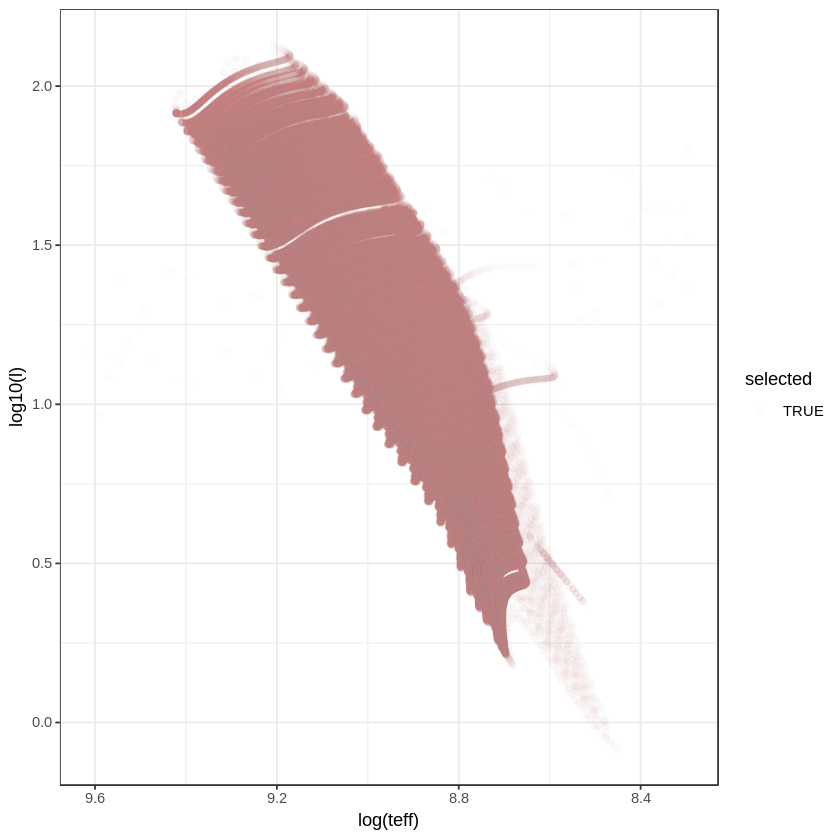

In [10]:
cond <- models$teff<15000&models$teff>4000&models$selected==T
ggplot(aes(log(teff), log10(l)), data=models[cond,]) +
    geom_point(aes(colour=selected), alpha=0.01) +     
   #stat_binhex(aes(colour=selected)) +
    scale_x_continuous(trans = "reverse") +
    theme_bw()

## Parallel process os each folder

In [11]:
selected_models <- models[cond,]
head(selected_models)

,xc,l,teff,selected,path
24,0.7289316,0.9084594,4789.307,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00023-m130fe-2a164o0rotjpzt5p5-ad.frq
25,0.7289285,0.9668952,4879.296,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00024-m130fe-2a164o0rotjpzt5p5-ad.frq
26,0.7289241,1.0464074,4980.346,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00025-m130fe-2a164o0rotjpzt5p5-ad.frq
27,0.7289181,1.1449021,5085.807,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00026-m130fe-2a164o0rotjpzt5p5-ad.frq
28,0.7289098,1.2635402,5194.434,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00027-m130fe-2a164o0rotjpzt5p5-ad.frq
29,0.7288984,1.4025684,5304.324,TRUE,VO-m130fe-2a164o0rotjpzt5p5-ad/00028-m130fe-2a164o0rotjpzt5p5-ad.frq


In [12]:
all_files <- as.character(selected_models$path)

In [13]:
cl <- parallel::makeCluster(8)
doParallel::registerDoParallel(cl)
foreach(i = all_files, .combine = 'c') %dopar% {
 # Get destination file
 chunks <- unlist(strsplit(as.character(i), "/"))
 filename <- chunks[length(chunks)]
 filename_chunks <- unlist(strsplit(filename, ".frq"))
 #if(!file.exists(paste0("~/Downloads/data/", filename_chunks, ".log"))){
  process_full_file(paste0(base_dir,"/",as.character(i)), resolution, cuts_breaks)
 #}
}

NULL

In [14]:
parallel::stopCluster(cl)